In [1]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

In [2]:
#Create a directory for the figures if it does not already exist.
os.makedirs('./Figures', exist_ok=True)

In [3]:
#Read in the cleaned data generated by Data_Cleaning. Save that data as a pandas dataframe, df.
df = pd.read_csv('./Cleaned_Data/V_Full_Data_wPCA.csv')

#Correcting cycle number. Original author's state that EIS measurements are taken every other cycle. 
#Therefore we should multiply the given cycles by 2 to get the true cycle number.
df["cycle number"] = df["cycle number"].apply(lambda x: 2*x)
df["Cycles Until Fail"] = df["Cycles Until Fail"].apply(lambda x: 2*x)#Correcting cycle number. Original author's state that EIS measurements are taken every other cycle. 

# Adding a classification taget and an additional feature that we can use for regression. 

# Adding a column for the true category (1 if the battery lasts over 200 cycles) (0 otherwise).
to_num=df['label']
to_num=to_num.map({'25C01':1.0,'25C02':0.0,'25C03':0.0,'25C04':0.0,'25C05':0.0,'25C06':0.0,'25C07':0.0,'25C08':0.0,
            '35C01':1.0,'35C02':1.0,'45C01':1.0,'45C02':1.0})
df['category']=to_num

# Adding temperature as a column. 
temdf=df['label']
temdf=temdf.map({'25C01':25.0,'25C02':25.0,'25C03':25.0,'25C04':25.0,'25C05':25.0,'25C06':25.0,'25C07':25.0,
                 '25C08':25.0,'35C01':35.0,'35C02':35.0,'45C01':45.0,'45C02':45.0})
df['temperature']=temdf

df[df['cycle number']==2]

,label,cycle number,Capacity/mA.h,Norm_Cap,Cycles Until Fail,20004.453 Re,15829.126 Re,12516.703 Re,9909.4424 Re,7835.48 Re,...,0.06443 Im,0.05102 Im,0.04042 Im,0.03192 Im,0.02528 Im,0.01999 Im,EIS_PCA_1,EIS_PCA_2,category,temperature
0,25C01,2,37.202713,1.0,234,0.38470,0.39156,0.39684,0.40341,0.40963,...,0.15473,0.18024,0.21535,0.25411,0.29026,0.32795,-0.648439,0.135808,1.0,25.0
261,25C02,2,35.060836,1.0,12,0.27315,0.28005,0.28916,0.29896,0.31009,...,0.16948,0.19432,0.23012,0.27316,0.31468,0.35528,0.997356,-0.606846,0.0,25.0
442,25C03,2,36.771703,1.0,164,0.26859,0.27977,0.28738,0.29862,0.31003,...,0.18334,0.21595,0.25083,0.28522,0.32480,0.37723,1.561054,-0.809891,0.0,25.0
644,25C04,2,35.534219,1.0,114,0.26546,0.27469,0.28046,0.29147,0.30112,...,0.18886,0.21123,0.24230,0.28393,0.32850,0.37336,1.061945,-0.751243,0.0,25.0
679,25C05,2,37.210831,1.0,152,0.34630,0.35399,0.35952,0.36615,0.37339,...,0.15592,0.17752,0.20654,0.23916,0.27151,0.31109,-1.097987,-0.006821,0.0,25.0
954,25C06,2,35.992184,1.0,120,0.29226,0.29988,0.30750,0.31758,0.32662,...,0.17112,0.19462,0.22959,0.27546,0.32275,0.36648,0.706666,-0.459589,0.0,25.0
1166,25C07,2,35.684646,1.0,32,0.30065,0.30717,0.31678,0.32634,0.33815,...,0.17637,0.20248,0.24127,0.28804,0.33312,0.37771,1.237057,-0.580435,0.0,25.0
1306,25C08,2,33.943672,1.0,32,0.28914,0.29589,0.30454,0.31619,0.32735,...,0.18095,0.20767,0.24267,0.28048,0.32001,0.37131,1.384369,-0.730253,0.0,25.0
1343,35C01,2,40.113305,1.0,218,0.27500,0.28167,0.28649,0.29203,0.29889,...,0.14148,0.15970,0.18417,0.21406,0.24424,0.27584,-2.642164,-0.091726,1.0,35.0
1670,35C02,2,40.473768,1.0,262,0.47084,0.47585,0.48147,0.48775,0.49372,...,0.13944,0.15736,0.18120,0.21156,0.24130,0.27295,-1.313667,0.634642,1.0,35.0


In [4]:
#Generate smaller, balanced dataframes with information from only early cycles. 

#Generate a dataframe with the first 20 cycles only
df_20 = df[(df['cycle number']<=20)]

In [5]:
#Functions to run Lasso and generate plots.         
    
def Train_Regr_ML(df,Train_L,model,feats):
    train_df = pd.DataFrame(columns = df.columns)
    for Label in Train_L:
            selected_rows = df[(df['label'] == Label)]
            train_df = pd.concat([train_df,selected_rows],ignore_index=True) 
    X_train = train_df[feats]
    y_train = train_df['Cycles Until Fail']
    
    #Running the Model
    regr = model
    regr.fit(X_train, y_train)
    
    #Return the trained model.
    return regr
    
#For testing batteries one at a time. 
def Test_Regr_Model(df,Test_Label,regr,feats):
    test_df = pd.DataFrame(columns = df.columns)
    selected_rows = df[(df['label'] == Test_Label)]
    test_df = pd.concat([test_df,selected_rows],ignore_index=True) 
    X_test = test_df[feats]
    y_test = test_df['Cycles Until Fail']
    #Convert y_test to numpy and rename
    true_C=y_test.to_numpy() 
    
    #Predict using the trained model
    regr_pred=regr.predict(X_test)
    
    #Return the predictions and the true values
    return regr_pred,true_C
    
def add_cycling(Pred,TruC):
    TotalP=[]
    TotalT=[]
    for i in range(len(Pred)):
        LP=np.arange(Pred[i],0,-1)
        LT=np.arange(TruC[i],TruC[i]-len(LP),-1)
        TotalP.append(LP)
        TotalT.append(LT)
    return TotalP,TotalT
        
    
def make_Cycling_Plots(Pred,TruC,label,save_info=False):
    title_string=str(label)
    TotalP,TotalT=add_cycling(Pred,TruC)
    xref=np.arange(0,TotalT[0][0],1)
    cerr=np.arange(0,len(TotalP),1)
    N=len(TotalP)
    cmap=plt.get_cmap('viridis',N)
    for i in range(len(TotalP)):
        plt.plot(TotalT[i],TotalP[i],c=cmap(i),alpha=0.8,linewidth=3.0)
    norm=mpl.colors.Normalize(vmin=2,vmax=2*len(TotalP))
    sm=plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    sm.set_array([])
    cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))
    cbar.set_label('Cycle')
    plt.plot(xref,xref,'k',linestyle='dashed',linewidth=3)
    plt.title(title_string)
    plt.xlabel('True RUL')
    plt.ylabel('Predicted RUL')
    if save_info != False:
        soc=str(save_info)
        save_str='./Figures/'+soc+'_Regr_'+label+'.png'
        plt.savefig(save_str,format='png',dpi=600)
    else:
        pass
    plt.show()
    

['20004.453 Im' '8.81772 Im' 'temperature']
[-2139.96935639  -318.65034428     9.51399186]
For Batterty 25C05 The Predicted RuL at Cycle 10 is: 140.26585233805088
The True RuL at Cycle 10 is: 144


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


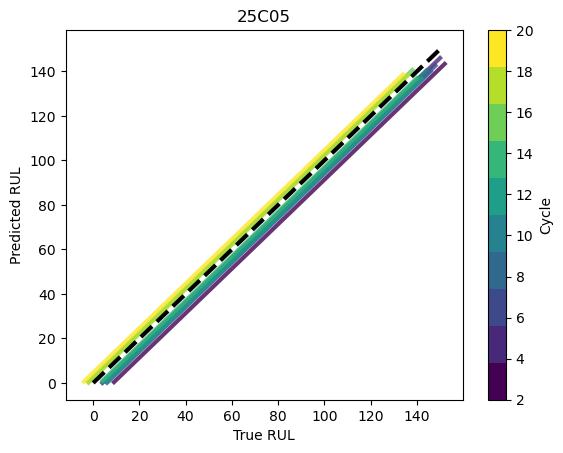

For Batterty 25C06 The Predicted RuL at Cycle 10 is: 84.86211132158996
The True RuL at Cycle 10 is: 112


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


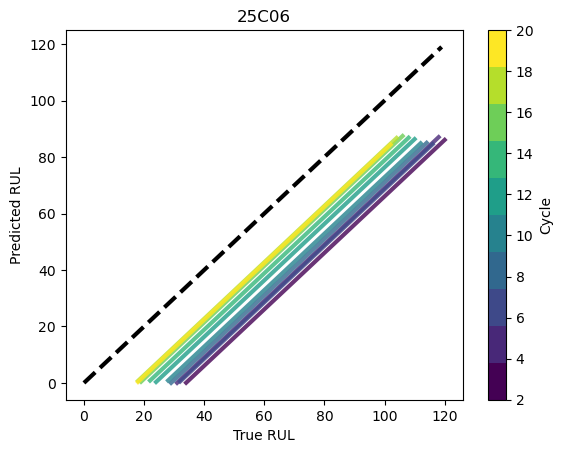

For Batterty 25C08 The Predicted RuL at Cycle 10 is: 62.35757089481595
The True RuL at Cycle 10 is: 24


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


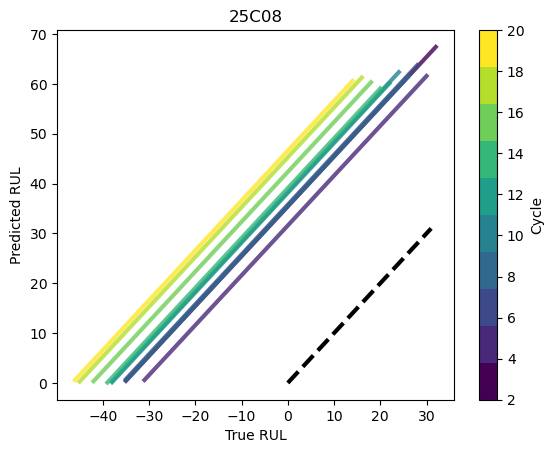

For Batterty 35C02 The Predicted RuL at Cycle 10 is: 252.59807432413913
The True RuL at Cycle 10 is: 254


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


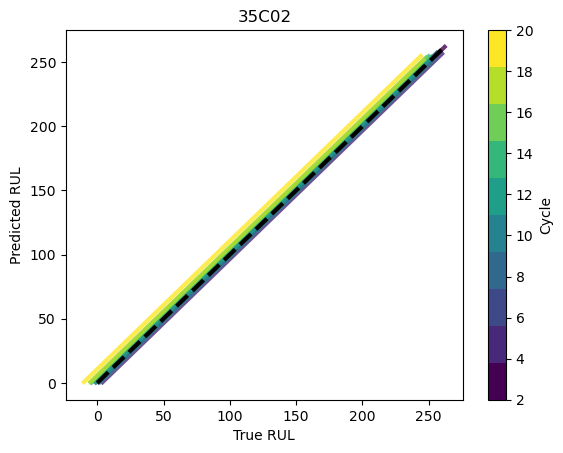

For Batterty 45C02 The Predicted RuL at Cycle 10 is: 377.57876631606723
The True RuL at Cycle 10 is: 380


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


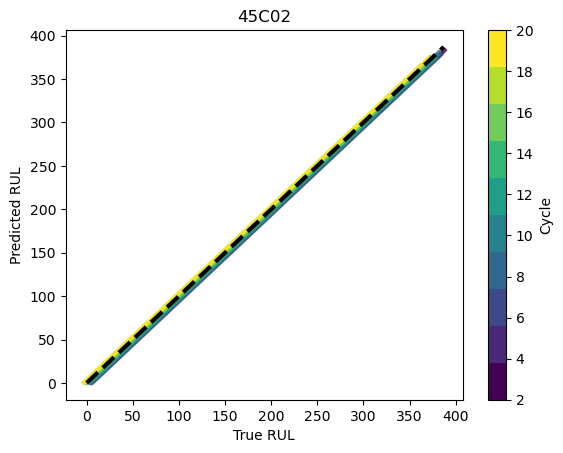

In [6]:
###
### First 20 cycles
### 20kHz and 8.8Hz
###
Train_Lst=['25C01','25C02','25C03','25C07','35C01','45C01']
Test_Lst=['25C05','25C06','25C08','35C02','45C02']
feats1=['20004.453 Im','8.81772 Im','temperature']
mydf=df_20

model = Lasso(alpha=0.05,random_state=42)
Trained_Model=Train_Regr_ML(mydf,Train_Lst,model,feats1)
print(Trained_Model.feature_names_in_)
print(Trained_Model.coef_)

all_Pred=np.array([])
all_True=np.array([])

for Label in Test_Lst:
    Pred,TruC=Test_Regr_Model(mydf,Label,Trained_Model,feats1)
    all_Pred=np.concatenate((all_Pred, Pred))
    all_True=np.concatenate((all_True, TruC))
    print('For Batterty',Label,'The Predicted RuL at Cycle 10 is:',Pred[4])
    print('The True RuL at Cycle 10 is:',TruC[4])
    make_Cycling_Plots(Pred,TruC,Label,save_info='V_20KHz_8Hz_Temp')
    



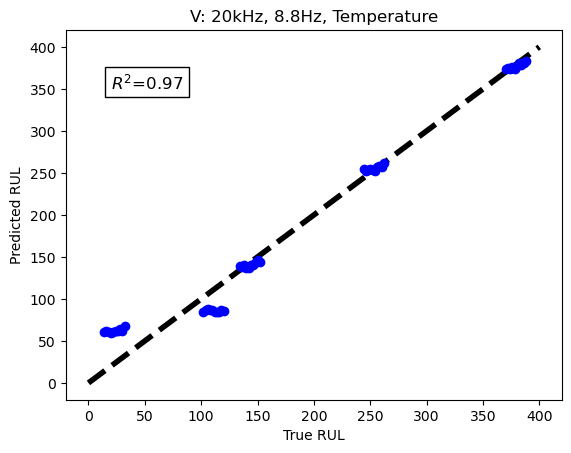

In [7]:
xref=np.linspace(0,400,400)
plt.plot(xref,xref,color='k',linestyle='dashed',linewidth=4,zorder=0)
plt.scatter(all_True,all_Pred,color='blue',zorder=1)
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('V: 20kHz, 8.8Hz, Temperature')
r2= r2_score(all_True,all_Pred)
R2string='$R^2$='+str(round(r2,3))
plt.text(20,350,R2string,fontsize='large',bbox=dict(facecolor='white'))
plt.savefig('./Figures/V_Regr_20k8HT.png',format='png',dpi=600)
plt.show()


['20004.453 Im' 'temperature']
[-3419.98585773    11.79699506]
For Batterty 25C05 The Predicted RuL at Cycle 10 is: 116.40093241905174
The True RuL at Cycle 10 is: 144


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


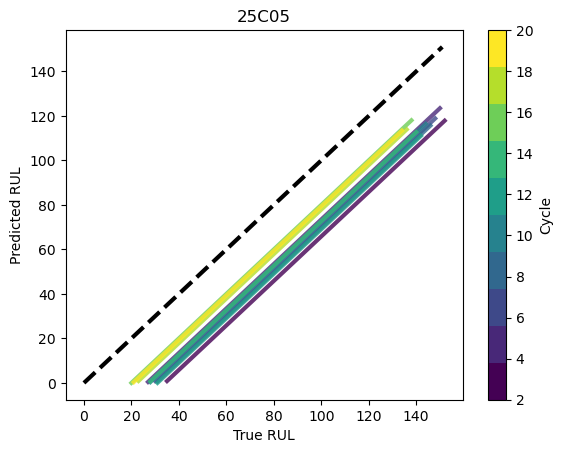

/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


For Batterty 25C06 The Predicted RuL at Cycle 10 is: 75.73730057069406
The True RuL at Cycle 10 is: 112


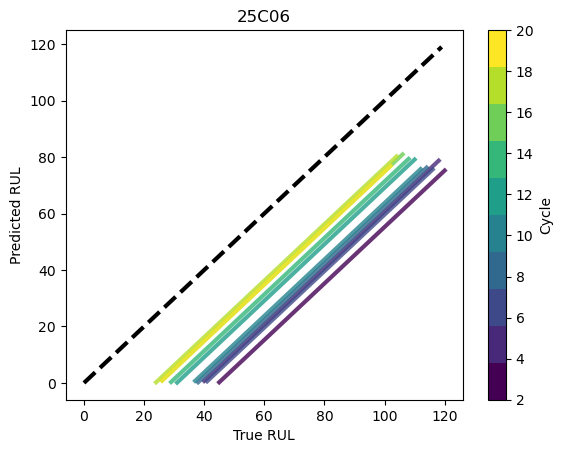

For Batterty 25C08 The Predicted RuL at Cycle 10 is: 71.70171725857784
The True RuL at Cycle 10 is: 24


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


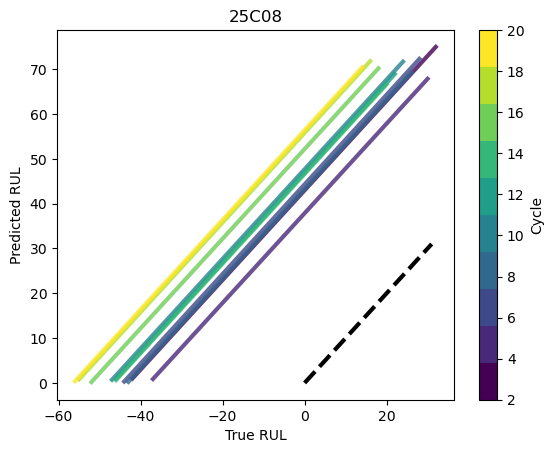

For Batterty 35C02 The Predicted RuL at Cycle 10 is: 232.52409067432632
The True RuL at Cycle 10 is: 254


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


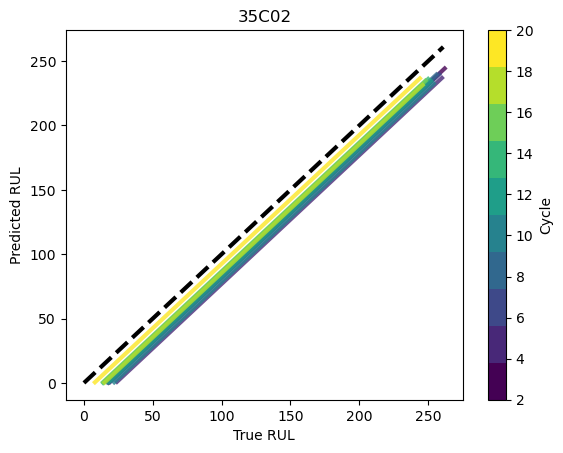

For Batterty 45C02 The Predicted RuL at Cycle 10 is: 384.93329888006986
The True RuL at Cycle 10 is: 380


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


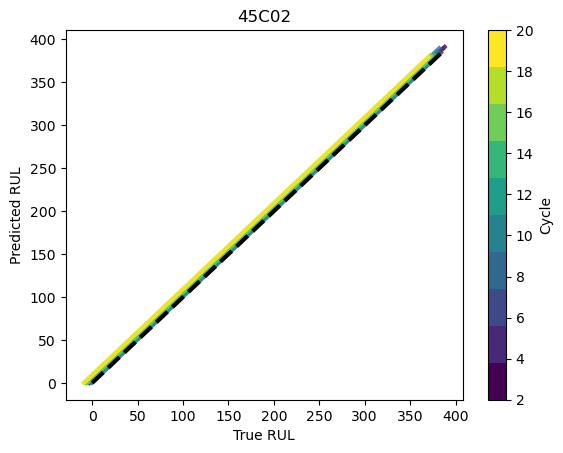

In [8]:
###
### First 20 cycles
### Only 20kHz
###
Train_Lst=['25C01','25C02','25C03','25C07','35C01','45C01']
Test_Lst=['25C05','25C06','25C08','35C02','45C02']
feats1=['20004.453 Im','temperature']
mydf=df_20

model = Lasso(alpha=0.1,random_state=42)
Trained_Model=Train_Regr_ML(mydf,Train_Lst,model,feats1)
print(Trained_Model.feature_names_in_)
print(Trained_Model.coef_)

all_Pred=np.array([])
all_True=np.array([])

for Label in Test_Lst:
    Pred,TruC=Test_Regr_Model(mydf,Label,Trained_Model,feats1)
    all_Pred=np.concatenate((all_Pred, Pred))
    all_True=np.concatenate((all_True, TruC))
    print('For Batterty',Label,'The Predicted RuL at Cycle 10 is:',Pred[4])
    print('The True RuL at Cycle 10 is:',TruC[4])
    make_Cycling_Plots(Pred,TruC,Label)
    


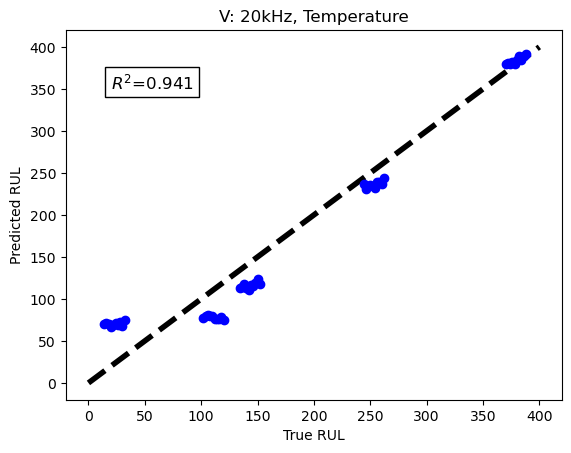

In [9]:
xref=np.linspace(0,400,400)
plt.plot(xref,xref,color='k',linestyle='dashed',linewidth=4,zorder=0)
plt.scatter(all_True,all_Pred,color='blue',zorder=1)
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('V: 20kHz, Temperature')
r2= r2_score(all_True,all_Pred)
R2string='$R^2$='+str(round(r2,3))
plt.text(20,350,R2string,fontsize='large',bbox=dict(facecolor='white'))
plt.savefig('./Figures/V_Regr_20kT.png',format='png',dpi=600)
plt.show()



['0.03192 Im' 'temperature']
[-762.44461739   11.07106135]
For Batterty 25C05 The Predicted RuL at Cycle 10 is: 120.37243138282034
The True RuL at Cycle 10 is: 144


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


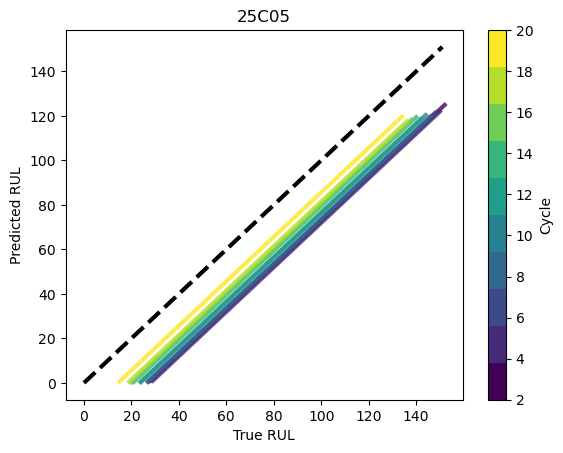

For Batterty

/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


 25C06 The Predicted RuL at Cycle 10 is: 97.90318850848394
The True RuL at Cycle 10 is: 112


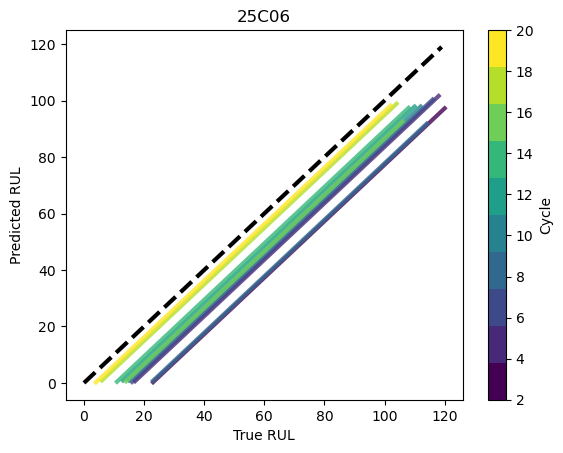

For Batterty 25C08 The Predicted RuL at Cycle 10 is: 86.68000374057655
The True RuL at Cycle 10 is: 24


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


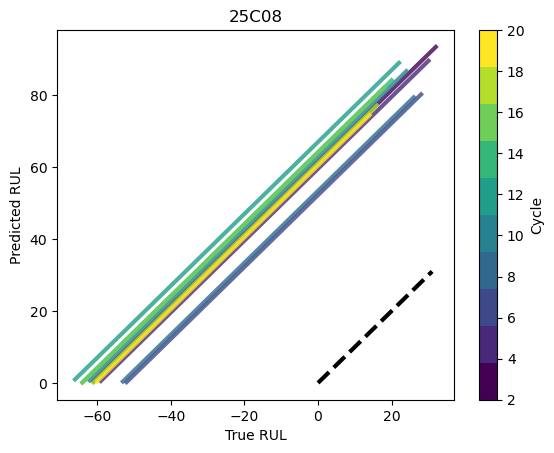

For Batterty 35C02 The Predicted RuL at Cycle 10 is: 252.67547640952722
The True RuL at Cycle 10 is: 254


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


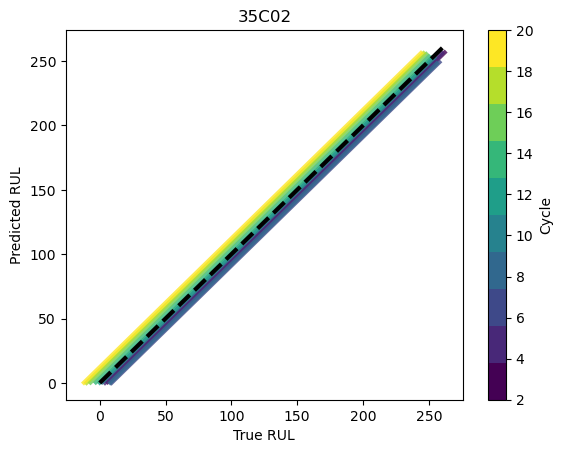

For Batterty 45C02 The Predicted RuL at Cycle 10 is: 379.1915667902819
The True RuL at Cycle 10 is: 380


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


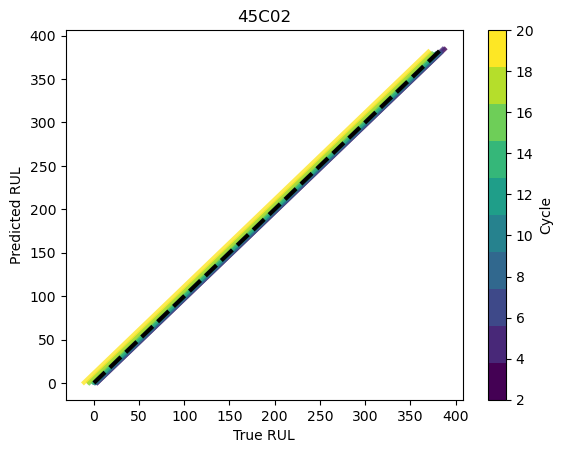

In [10]:
###
### First 20 cycles
### Only 0.03Hz
###
Train_Lst=['25C01','25C02','25C03','25C07','35C01','45C01']
Test_Lst=['25C05','25C06','25C08','35C02','45C02']
feats1=['0.03192 Im','temperature']
mydf=df_20

model = Lasso(alpha=0.1,random_state=42)
Trained_Model=Train_Regr_ML(mydf,Train_Lst,model,feats1)
print(Trained_Model.feature_names_in_)
print(Trained_Model.coef_)

all_Pred=np.array([])
all_True=np.array([])

for Label in Test_Lst:
    Pred,TruC=Test_Regr_Model(mydf,Label,Trained_Model,feats1)
    all_Pred=np.concatenate((all_Pred, Pred))
    all_True=np.concatenate((all_True, TruC))
    print('For Batterty',Label,'The Predicted RuL at Cycle 10 is:',Pred[4])
    print('The True RuL at Cycle 10 is:',TruC[4])
    make_Cycling_Plots(Pred,TruC,Label)

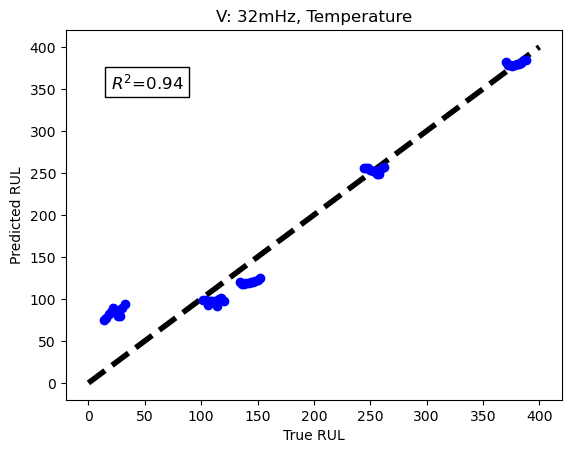

In [11]:
xref=np.linspace(0,400,400)
plt.plot(xref,xref,color='k',linestyle='dashed',linewidth=4,zorder=0)
plt.scatter(all_True,all_Pred,color='blue',zorder=1)
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('V: 32mHz, Temperature')
r2= r2_score(all_True,all_Pred)
R2string='$R^2$='+str(round(r2,3))
plt.text(20,350,R2string,fontsize='large',bbox=dict(facecolor='white'))
plt.savefig('./Figures/V_Regr_32mT.png',format='png',dpi=600)
plt.show()


['8.81772 Im' 'temperature']
[-532.91177497    9.00393829]
For Batterty 25C05 The Predicted RuL at Cycle 10 is: 149.17281560254358
The True RuL at Cycle 10 is: 144


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


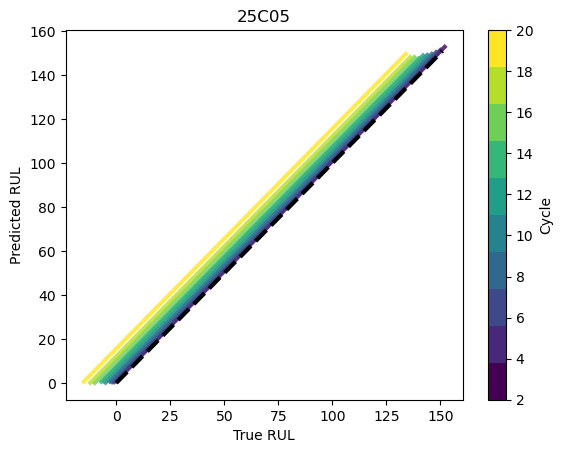

/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


For Batterty 25C06 The Predicted RuL at Cycle 10 is: 99.06845052015534
The True RuL at Cycle 10 is: 112


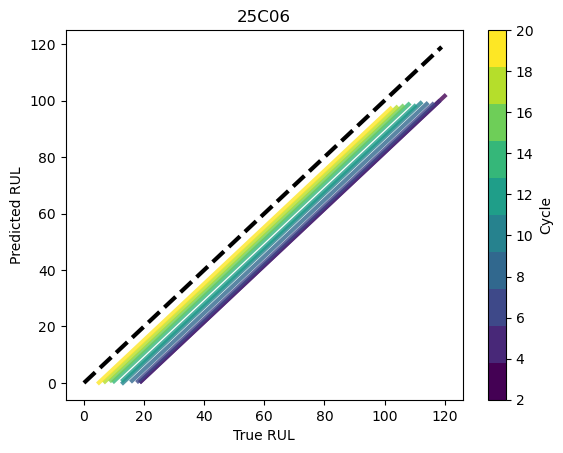

For Batterty 25C08 The Predicted RuL at Cycle 10 is: 65.6548822297305
The True RuL at Cycle 10 is: 24


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


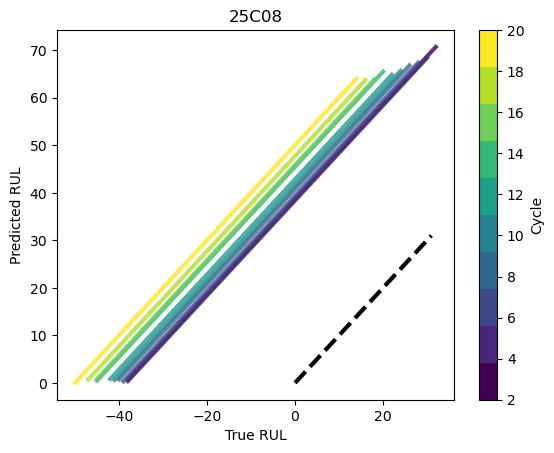

For Batterty 35C02 The Predicted RuL at Cycle 10 is: 269.89725845913745
The True RuL at Cycle 10 is: 254


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


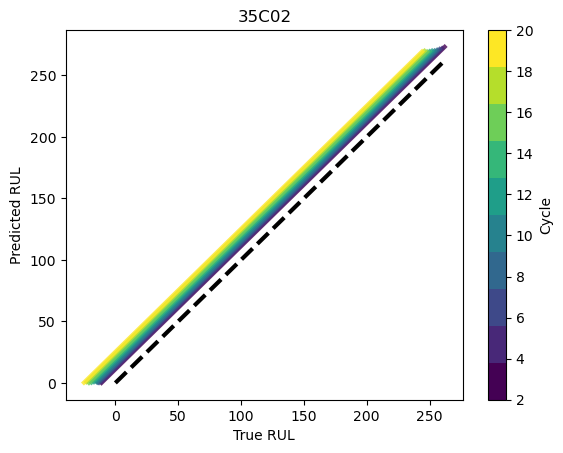

/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


For Batterty 45C02 The Predicted RuL at Cycle 10 is: 373.80300569777586
The True RuL at Cycle 10 is: 380


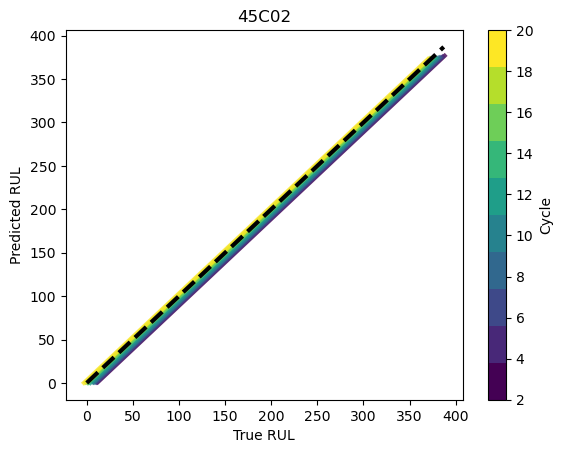

In [18]:
###
### First 20 cycles
### Only 8.8Hz
###
Train_Lst=['25C01','25C02','25C03','25C07','35C01','45C01']
Test_Lst=['25C05','25C06','25C08','35C02','45C02']
feats1=['8.81772 Im','temperature']
mydf=df_20

model = Lasso(alpha=0.1,random_state=42)
Trained_Model=Train_Regr_ML(mydf,Train_Lst,model,feats1)
print(Trained_Model.feature_names_in_)
print(Trained_Model.coef_)

all_Pred=np.array([])
all_True=np.array([])

for Label in Test_Lst:
    Pred,TruC=Test_Regr_Model(mydf,Label,Trained_Model,feats1)
    all_Pred=np.concatenate((all_Pred, Pred))
    all_True=np.concatenate((all_True, TruC))
    print('For Batterty',Label,'The Predicted RuL at Cycle 10 is:',Pred[4])
    print('The True RuL at Cycle 10 is:',TruC[4])
    make_Cycling_Plots(Pred,TruC,Label)

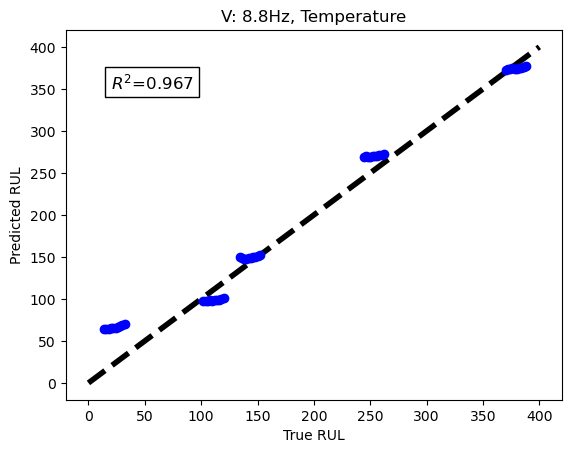

In [19]:
xref=np.linspace(0,400,400)
plt.plot(xref,xref,color='k',linestyle='dashed',linewidth=4,zorder=0)
plt.scatter(all_True,all_Pred,color='blue',zorder=1)
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('V: 8.8Hz, Temperature')
r2= r2_score(all_True,all_Pred)
R2string='$R^2$='+str(round(r2,3))
plt.text(20,350,R2string,fontsize='large',bbox=dict(facecolor='white'))
plt.savefig('./Figures/V_Regr_8HT.png',format='png',dpi=600)
plt.show()


['17.79613 Im' '2.16054 Im' 'temperature']
[-2.38966445e+03  1.90013596e+03  1.81737290e+00]
For Batterty 25C05 The Predicted RuL at Cycle 10 is: 168.73227382322779
The True RuL at Cycle 10 is: 144


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


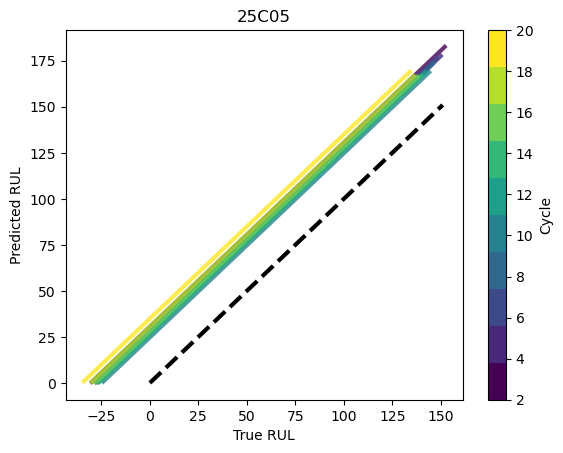

For Batterty 25C06 The Predicted RuL at Cycle 10 is: 44.4755719247309
The True RuL at Cycle 10 is: 112


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


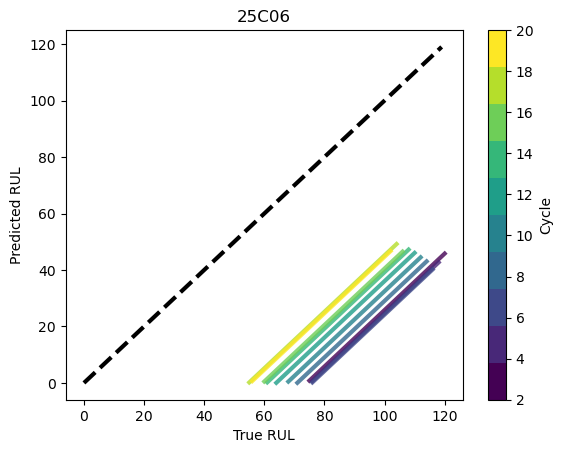

For Batterty 25C08 The Predicted RuL at Cycle 10 is: 130.9285566358564
The True RuL at Cycle 10 is: 24


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


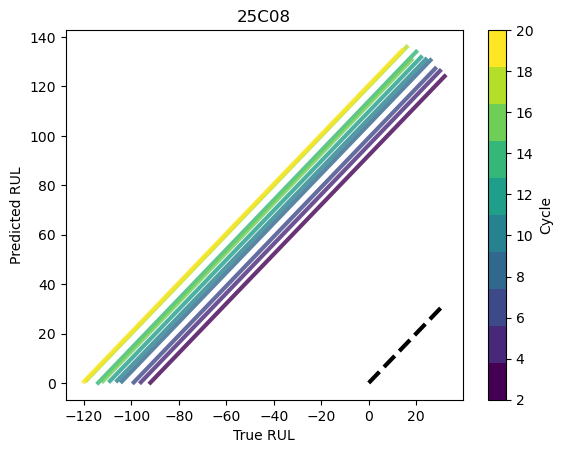

/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


For Batterty 35C02 The Predicted RuL at Cycle 10 is: 286.50532621409036
The True RuL at Cycle 10 is: 254


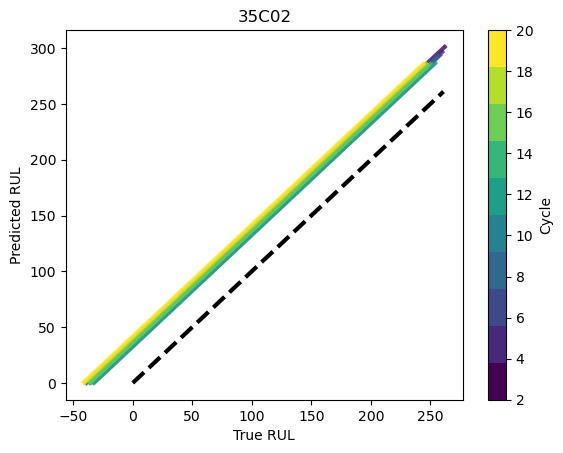

For Batterty 45C02 The Predicted RuL at Cycle 10 is: 370.7647585275338
The True RuL at Cycle 10 is: 380


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


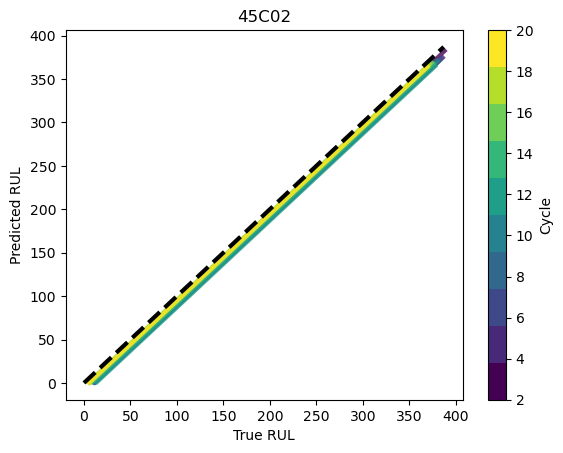

In [12]:
###
### First 20 cycles
### ARD frequencies from refernce paper plus temperature. 
###
Train_Lst=['25C01','25C02','25C03','25C07','35C01','45C01']
Test_Lst=['25C05','25C06','25C08','35C02','45C02']
feats1=['17.79613 Im','2.16054 Im','temperature']
mydf=df_20

model = Lasso(alpha=0.1,random_state=42)
Trained_Model=Train_Regr_ML(mydf,Train_Lst,model,feats1)
print(Trained_Model.feature_names_in_)
print(Trained_Model.coef_)

all_Pred=np.array([])
all_True=np.array([])

for Label in Test_Lst:
    Pred,TruC=Test_Regr_Model(mydf,Label,Trained_Model,feats1)
    all_Pred=np.concatenate((all_Pred, Pred))
    all_True=np.concatenate((all_True, TruC))
    print('For Batterty',Label,'The Predicted RuL at Cycle 10 is:',Pred[4])
    print('The True RuL at Cycle 10 is:',TruC[4])
    make_Cycling_Plots(Pred,TruC,Label)

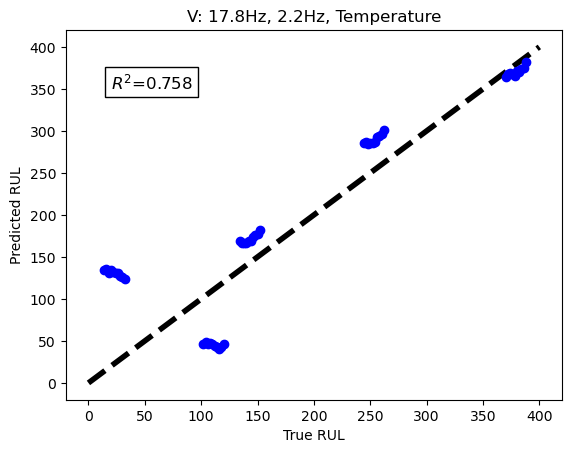

In [13]:
xref=np.linspace(0,400,400)
plt.plot(xref,xref,color='k',linestyle='dashed',linewidth=4,zorder=0)
plt.scatter(all_True,all_Pred,color='blue',zorder=1)
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('V: 17.8Hz, 2.2Hz, Temperature')
r2= r2_score(all_True,all_Pred)
R2string='$R^2$='+str(round(r2,3))
plt.text(20,350,R2string,fontsize='large',bbox=dict(facecolor='white'))
plt.savefig('./Figures/V_Regr_RefT.png',format='png',dpi=600)
plt.show()


['20004.453 Re' '15829.126 Re' '12516.703 Re' '9909.4424 Re' '7835.48 Re'
 '6217.2461 Re' '4905.291 Re' '3881.2737 Re' '3070.9827 Re' '2430.7778 Re'
 '1923.1537 Re' '1522.4358 Re' '1203.8446 Re' '952.86591 Re'
 '754.27557 Re' '596.71857 Re' '471.96338 Re' '373.20856 Re'
 '295.47278 Re' '233.87738 Re' '185.05922 Re' '146.35823 Re'
 '115.77804 Re' '91.6721 Re' '72.51701 Re' '57.36816 Re' '45.3629 Re'
 '35.93134 Re' '28.40909 Re' '22.48202 Re' '17.79613 Re' '14.06813 Re'
 '11.1448 Re' '8.81772 Re' '6.97545 Re' '5.5173 Re' '4.36941 Re'
 '3.45686 Re' '2.73547 Re' '2.16054 Re' '1.70952 Re' '1.35352 Re'
 '1.07079 Re' '0.84734 Re' '0.67072 Re' '0.53067 Re' '0.41976 Re'
 '0.33183 Re' '0.26261 Re' '0.20791 Re' '0.16452 Re' '0.13007 Re'
 '0.10309 Re' '0.08153 Re' '0.06443 Re' '0.05102 Re' '0.04042 Re'
 '0.03192 Re' '0.02528 Re' '0.01999 Re' '20004.453 Im' '15829.126 Im'
 '12516.703 Im' '9909.4424 Im' '7835.48 Im' '6217.2461 Im' '4905.291 Im'
 '3881.2737 Im' '3070.9827 Im' '2430.7778 Im' '1923.153

/Users/christian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.694e+03, tolerance: 1.097e+02
  model = cd_fast.enet_coordinate_descent(
/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


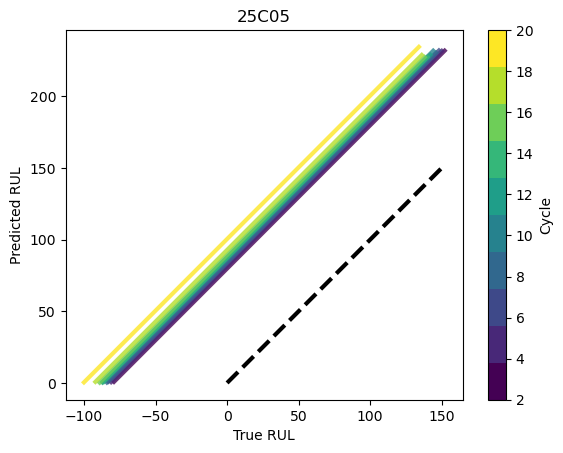

/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


For Batterty 25C06 The Predicted RuL at Cycle 10 is: 49.69577776973256
The True RuL at Cycle 10 is: 112


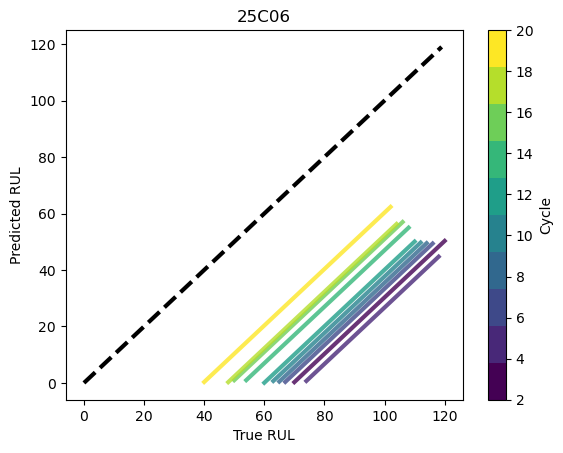

For Batterty 25C08 The Predicted RuL at Cycle 10 is: 131.07519354295937
The True RuL at Cycle 10 is: 24


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


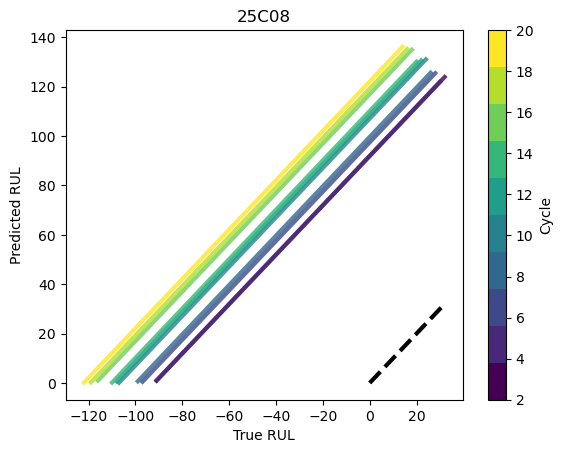

For Batterty 35C02 The Predicted RuL at Cycle 10 is: 242.62568272290787
The True RuL at Cycle 10 is: 254


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


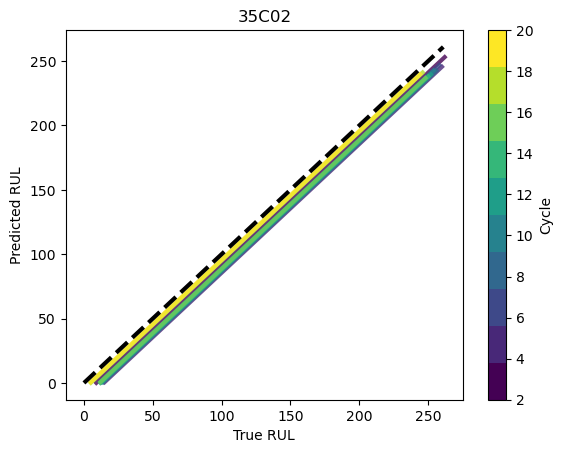

For Batterty 45C02 The Predicted RuL at Cycle 10 is: 250.86927605445004
The True RuL at Cycle 10 is: 380


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


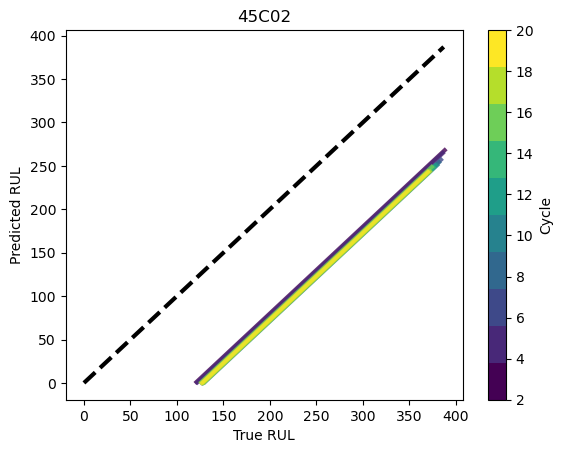

In [14]:
###
### All EIS
###
Train_Lst=['25C01','25C02','25C03','25C07','35C01','45C01']
Test_Lst=['25C05','25C06','25C08','35C02','45C02']
feats1=df_20.columns.to_list()[5:125]+['temperature']
mydf=df_20

model = Lasso(alpha=0.2,random_state=42)
Trained_Model=Train_Regr_ML(mydf,Train_Lst,model,feats1)
print(Trained_Model.feature_names_in_)
print(Trained_Model.coef_)

all_Pred=np.array([])
all_True=np.array([])

for Label in Test_Lst:
    Pred,TruC=Test_Regr_Model(mydf,Label,Trained_Model,feats1)
    all_Pred=np.concatenate((all_Pred, Pred))
    all_True=np.concatenate((all_True, TruC))
    print('For Batterty',Label,'The Predicted RuL at Cycle 10 is:',Pred[4])
    print('The True RuL at Cycle 10 is:',TruC[4])
    make_Cycling_Plots(Pred,TruC,Label)

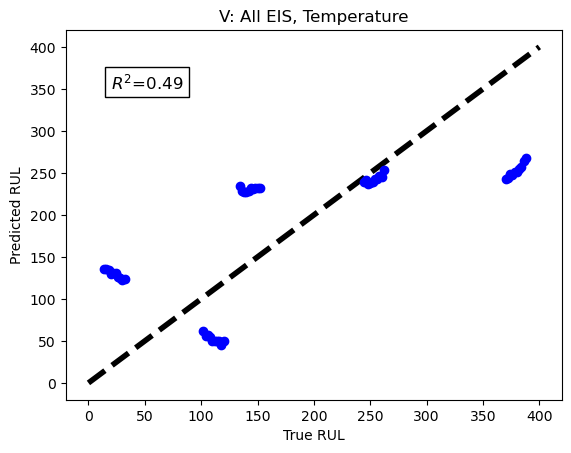

In [15]:
xref=np.linspace(0,400,400)
plt.plot(xref,xref,color='k',linestyle='dashed',linewidth=4,zorder=0)
plt.scatter(all_True,all_Pred,color='blue',zorder=1)
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('V: All EIS, Temperature')
r2= r2_score(all_True,all_Pred)
R2string='$R^2$='+str(round(r2,3))
plt.text(20,350,R2string,fontsize='large',bbox=dict(facecolor='white'))
plt.savefig('./Figures/V_Regr_All.png',format='png',dpi=600)
plt.show()


['EIS_PCA_1' 'EIS_PCA_2' 'temperature']
[-24.64240455  84.96936985  -0.7024108 ]
For Batterty 25C05 The Predicted RuL at Cycle 10 is: 190.37317113072868
The True RuL at Cycle 10 is: 144


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


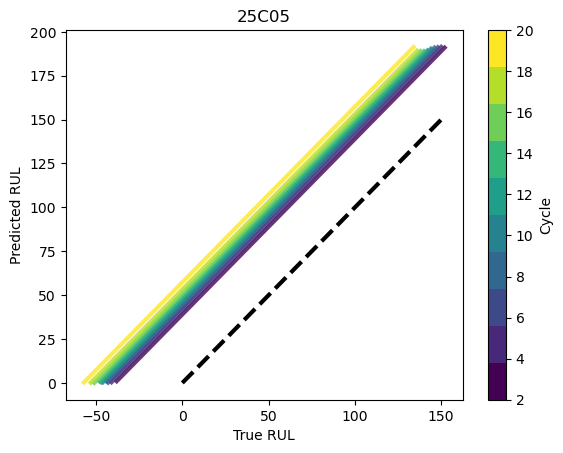

/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


For Batterty 25C06 The Predicted RuL at Cycle 10 is: 104.48361918767787
The True RuL at Cycle 10 is: 112


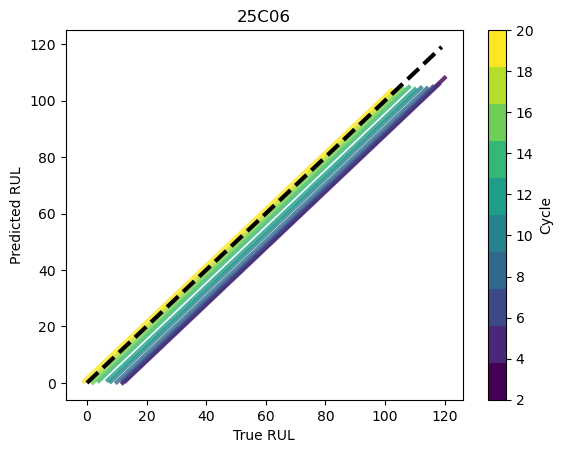

For Batterty 25C08 The Predicted RuL at Cycle 10 is: 60.568992980461346
The True RuL at Cycle 10 is: 24


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


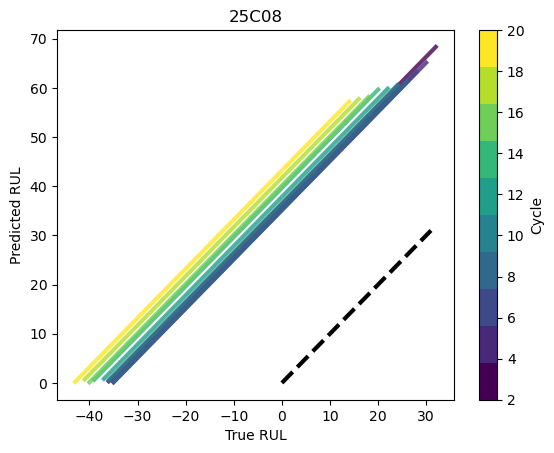

/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


For Batterty 35C02 The Predicted RuL at Cycle 10 is: 238.95361738485792
The True RuL at Cycle 10 is: 254


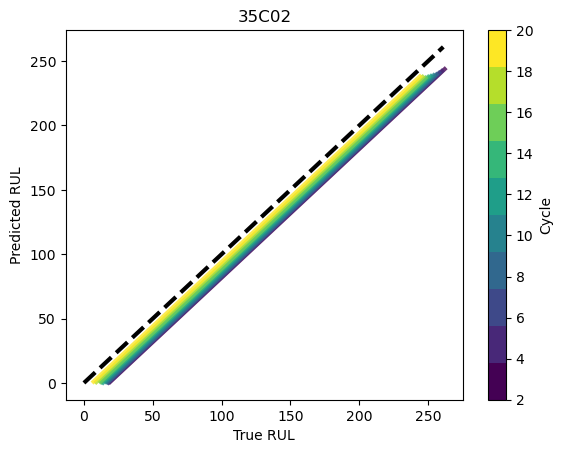

For Batterty 45C02 The Predicted RuL at Cycle 10 is: 266.5663746998334
The True RuL at Cycle 10 is: 380


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_22768/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


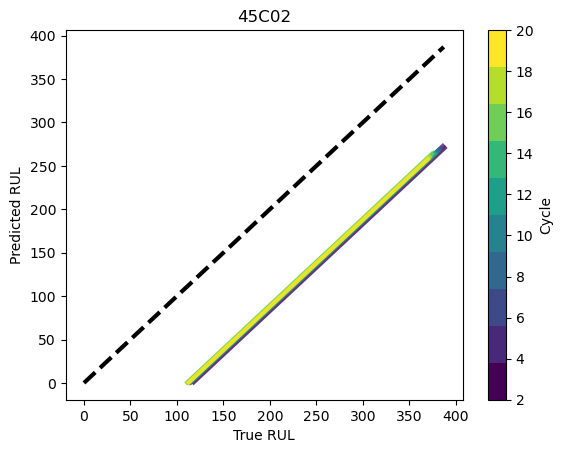

In [16]:
###
### PCA
###
Train_Lst=['25C01','25C02','25C03','25C07','35C01','45C01']
Test_Lst=['25C05','25C06','25C08','35C02','45C02']
feats1=['EIS_PCA_1','EIS_PCA_2','temperature']
mydf=df_20

model = Lasso(alpha=0.2,random_state=42)
Trained_Model=Train_Regr_ML(mydf,Train_Lst,model,feats1)
print(Trained_Model.feature_names_in_)
print(Trained_Model.coef_)

all_Pred=np.array([])
all_True=np.array([])

for Label in Test_Lst:
    Pred,TruC=Test_Regr_Model(mydf,Label,Trained_Model,feats1)
    all_Pred=np.concatenate((all_Pred, Pred))
    all_True=np.concatenate((all_True, TruC))
    print('For Batterty',Label,'The Predicted RuL at Cycle 10 is:',Pred[4])
    print('The True RuL at Cycle 10 is:',TruC[4])
    make_Cycling_Plots(Pred,TruC,Label)

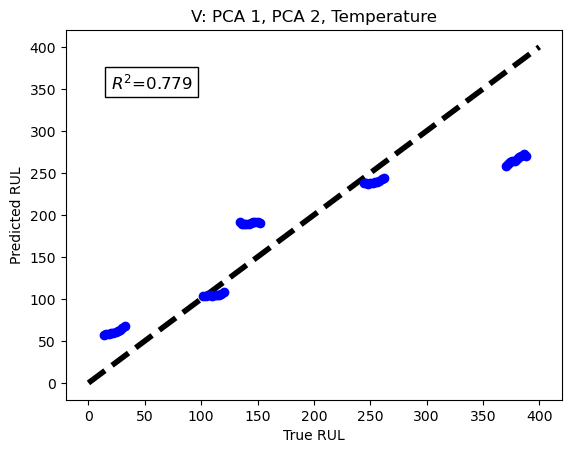

In [17]:
xref=np.linspace(0,400,400)
plt.plot(xref,xref,color='k',linestyle='dashed',linewidth=4,zorder=0)
plt.scatter(all_True,all_Pred,color='blue',zorder=1)
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('V: PCA 1, PCA 2, Temperature')
r2= r2_score(all_True,all_Pred)
R2string='$R^2$='+str(round(r2,3))
plt.text(20,350,R2string,fontsize='large',bbox=dict(facecolor='white'))
plt.savefig('./Figures/V_Regr_PCA.png',format='png',dpi=600)
plt.show()
